Prediction task is to determine whether a person makes over 50K a year.

# Functions

In [1]:
#changing datatype
def change_type_to_date(df, to_date):
        # Deal with incorrect data in date column
    for i in to_date:
        df[i] = pd.to_datetime(df[i], errors='coerce')
    return df

  # columns to convert to categorical format
def change_type_to_cat(df, to_cat):
        # Deal with incorrect data in numeric columns
        for i in to_cat:
            df[i] = df[i].astype('category')
        return df

#Plot data
def plot_data(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    data.plot(ax=ax)
    ax.set(ylabel='Islands')
    sns.despine()
    
#KDE plot
def kde_plot(data):
    az.plot_kde(data.values, rug=True)
    plt.yticks([0], alpha=0);
    
    
#prior predictive check
def prior_Predictive_Check(model):
    with model:
        prior_pred = pm.sample_prior_predictive()
    return prior_pred

#prior plot
def Prior_predictive_check_plot(y, prior_pred, y_var):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([y.mean() for y in prior_pred[y_var]], bins=19, alpha=0.7)
    ax.axvline(data.mean().item())
    ax.set(title='Prior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
    
#Fitting the model
def fit_model(model, draws=10):
    with model:
    # Inference button (TM)
        trace = pm.sample(draws)
    return trace

#posterior predictive check
def post_Predictive_Check(model, trace, samples=10):
    with model:
        post_pred = pm.sample_posterior_predictive(trace, samples, model=model)
    return post_pred


#post plot
def Post_predictive_check_plot(y, post_pred, y_var):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.hist([y.mean() for y in post_pred['y']], bins=19, alpha=0.5)
    ax.axvline(data.mean().item())
    ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
        
#posterior plot comparasion with observed data
def compare(post_pred, trace):
    data_ppc = az.from_pymc3(trace=trace, posterior_predictive=post_pred)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    #ax[0].legend(fontsize=15)
    fig, axs = plt.subplots(3)

# WorkFlow
1) Loading Data

2) Performing EDA

3) Ploting the data and find out the distribution of data

4) Fitting distributions

5) Guassian inference

6) Build the model (decide proir distribution and likelihood distribution on given data)

7) Run the prior predictive check, usually we have less intuition about the prior data, so it is good to always check the prior data. It allows us to make sure the model can generate the types of data we expect to see.

8) Fit the model

9) Assess convergence

10) Summary of the posterior distribution for each parameter.

11) Run posterior predictive check

12) Using Machine Learning for comparing

### Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
#from fitter import Fitter, get_common_distributions, get_distributions
import warnings
warnings.simplefilter("ignore")

### 1) Loading Dataset

In [3]:
df = pd.read_csv('adult.csv')

In [5]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


### 2) Performing EDA

Replacing text with 0 for less than 50k and 1 for greater or equal to 50k

In [4]:
df["income"].replace({">50K": 1, "<=50K": 0}, inplace=True)

Checking number of counts per catergory

In [ ]:
df['income'].value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [3]:
#df[df['native-country']== 'United-States']

Total Columns

In [ ]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

The below chart shows that mostly people are working in a private firm

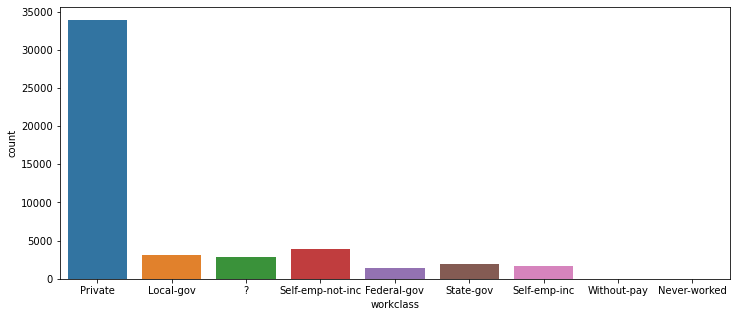

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.countplot(data=df, x='workclass', ax=ax)
plt.show()

The below chart shows the gender along with races and mostly data belongs to white male

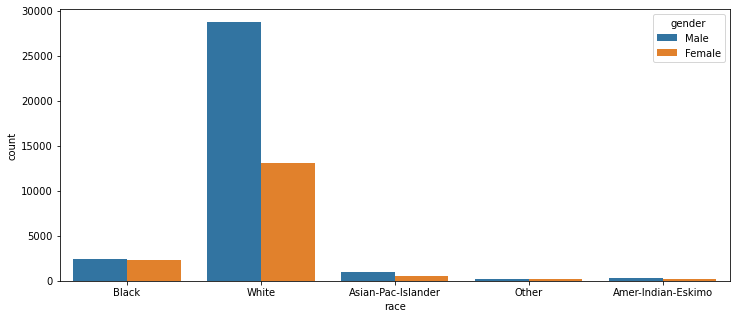

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.countplot(data=df, x='race', ax=ax, hue='gender')
plt.show()

Checking the data whether contains null values or not

In [ ]:
print(df.isna().sum())

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


Renaming the columns for our ease

In [5]:
df = df.rename(columns={'hours-per-week': 'hours_per_week'})

In [6]:
df = df.rename(columns={'educational-num': 'educational_num'})

We will be using 3 features here, so we are making new dataframe data and put only these 3 features

In [7]:
data = df[['age', 'educational_num','hours_per_week', 'income']]

checking the shape of dataset

In [ ]:
data.shape

(48842, 4)

In [8]:
income = df['income']

In [9]:
data['income'] = income

### 3) Guassian inference

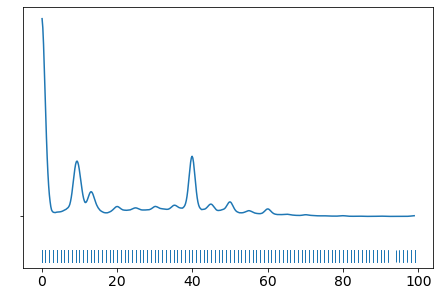

In [ ]:
#plotting your data and check the pdf of your data
kde_plot(data)

### 4) Build model

here we have used GLM model (one can use bambi instead of GLM)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [hours_per_week, educational_num, age, Intercept]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 5573 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


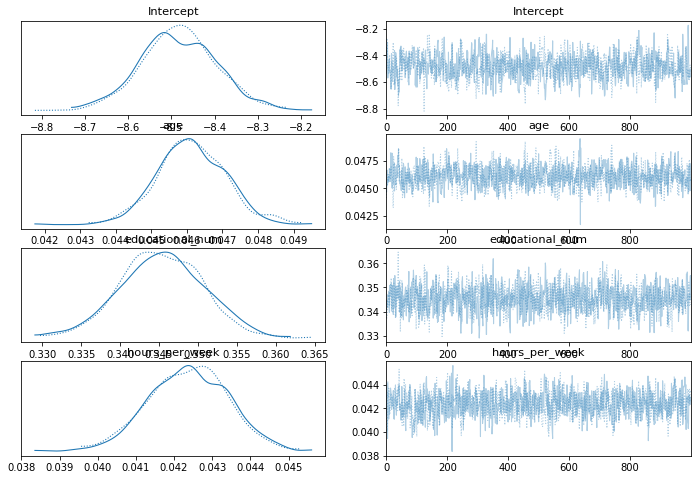

In [22]:
with pm.Model() as third_model:
    pm.glm.GLM.from_formula('income ~ age + educational_num + hours_per_week', data=data,
                            family=pm.glm.families.Binomial())
    third_trace = pm.sample(1000, tune=10000, init='adapt_diag')
pm.traceplot(third_trace)
plt.show()

From above samples, you can see our model does converge.

Checking the variable names

In [15]:
trace.varnames

['Intercept', 'age', 'educational_num', 'hours_per_week', 'sd_log__', 'sd']

In [16]:
trace['age']

array([0.00648537, 0.00644305, 0.0065088 , 0.00653526, 0.00642941,
       0.00645542, 0.00633544, 0.00660211, 0.00647094, 0.0066396 ,
       0.00625119, 0.00634654, 0.00659934, 0.00661256, 0.00662943,
       0.00652682, 0.00649274, 0.00647723, 0.00659669, 0.00662186,
       0.00649373, 0.00663123, 0.00643787, 0.00659534, 0.00646764,
       0.00655805, 0.00656521, 0.00663579, 0.0066762 , 0.00659951,
       0.00646578, 0.00655115, 0.00655131, 0.00650052, 0.00652497,
       0.00650666, 0.00633414, 0.00650541, 0.00656105, 0.00658427,
       0.0066025 , 0.00666976, 0.0065221 , 0.00656898, 0.00651361,
       0.00646012, 0.00665116, 0.00644548, 0.00664866, 0.0066062 ,
       0.00617936, 0.00668684, 0.00657429, 0.00629399, 0.00666389,
       0.00637991, 0.00656367, 0.00659804, 0.00646557, 0.00658036,
       0.00667897, 0.00636227, 0.00658452, 0.00637465, 0.00656999,
       0.00660162, 0.00645445, 0.00644115, 0.00657317, 0.00658284,
       0.00637962, 0.00662747, 0.00653565, 0.00631324, 0.00638

Summary of features

In [23]:
pm.summary(third_trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-8.483,0.089,-8.671,-8.331,0.004,0.003,612.0,739.0,1.0
age,0.046,0.001,0.044,0.048,0.000,0.000,845.0,972.0,1.0
educational_num,0.345,0.005,0.336,0.355,0.000,0.000,1034.0,1195.0,1.0
hours_per_week,0.042,0.001,0.040,0.044,0.000,0.000,965.0,1028.0,1.0


Checking the mean and standard deviation of our feature variable. It can also help to compare our bayesian model with ML model

In [24]:
with third_model:
    map_solution=pm.find_MAP()
d=dict()
for item in map_solution.keys():
    d[item]=[float(map_solution[item])]
    
third_map_coeffs=pd.DataFrame.from_dict(d)    
third_map_coeffs

,Intercept,age,educational_num,hours_per_week
0,-8.479077,0.046104,0.345158,0.042358


checking samples of individual features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f626bc9a250>,
      dtype=object)

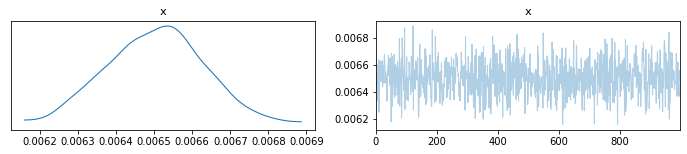

In [18]:
#with sal_model:
pm.traceplot(trace['age'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f625d59eb50>,
      dtype=object)

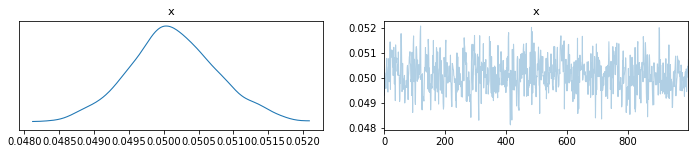

In [20]:
pm.traceplot(trace['educational_num'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6259e61c10>,
      dtype=object)

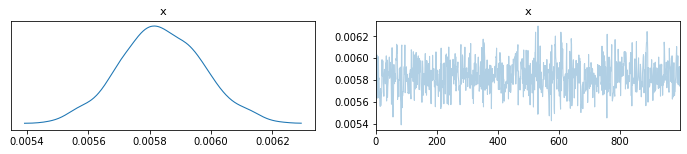

In [21]:
pm.traceplot(trace['hours_per_week'])

In [23]:
#import bambi as bmb
# Initialize the fixed effects only model
#model = bmb.Model('income ~ age + age2 + educational_num + hours_per_week', data=data)

Got error No model on context stack. trying to find log_likelihood in translation.


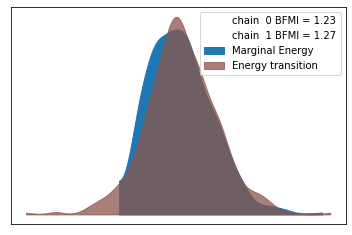

In [24]:
pm.plot_energy(trace);

Got error No model on context stack. trying to find log_likelihood in translation.


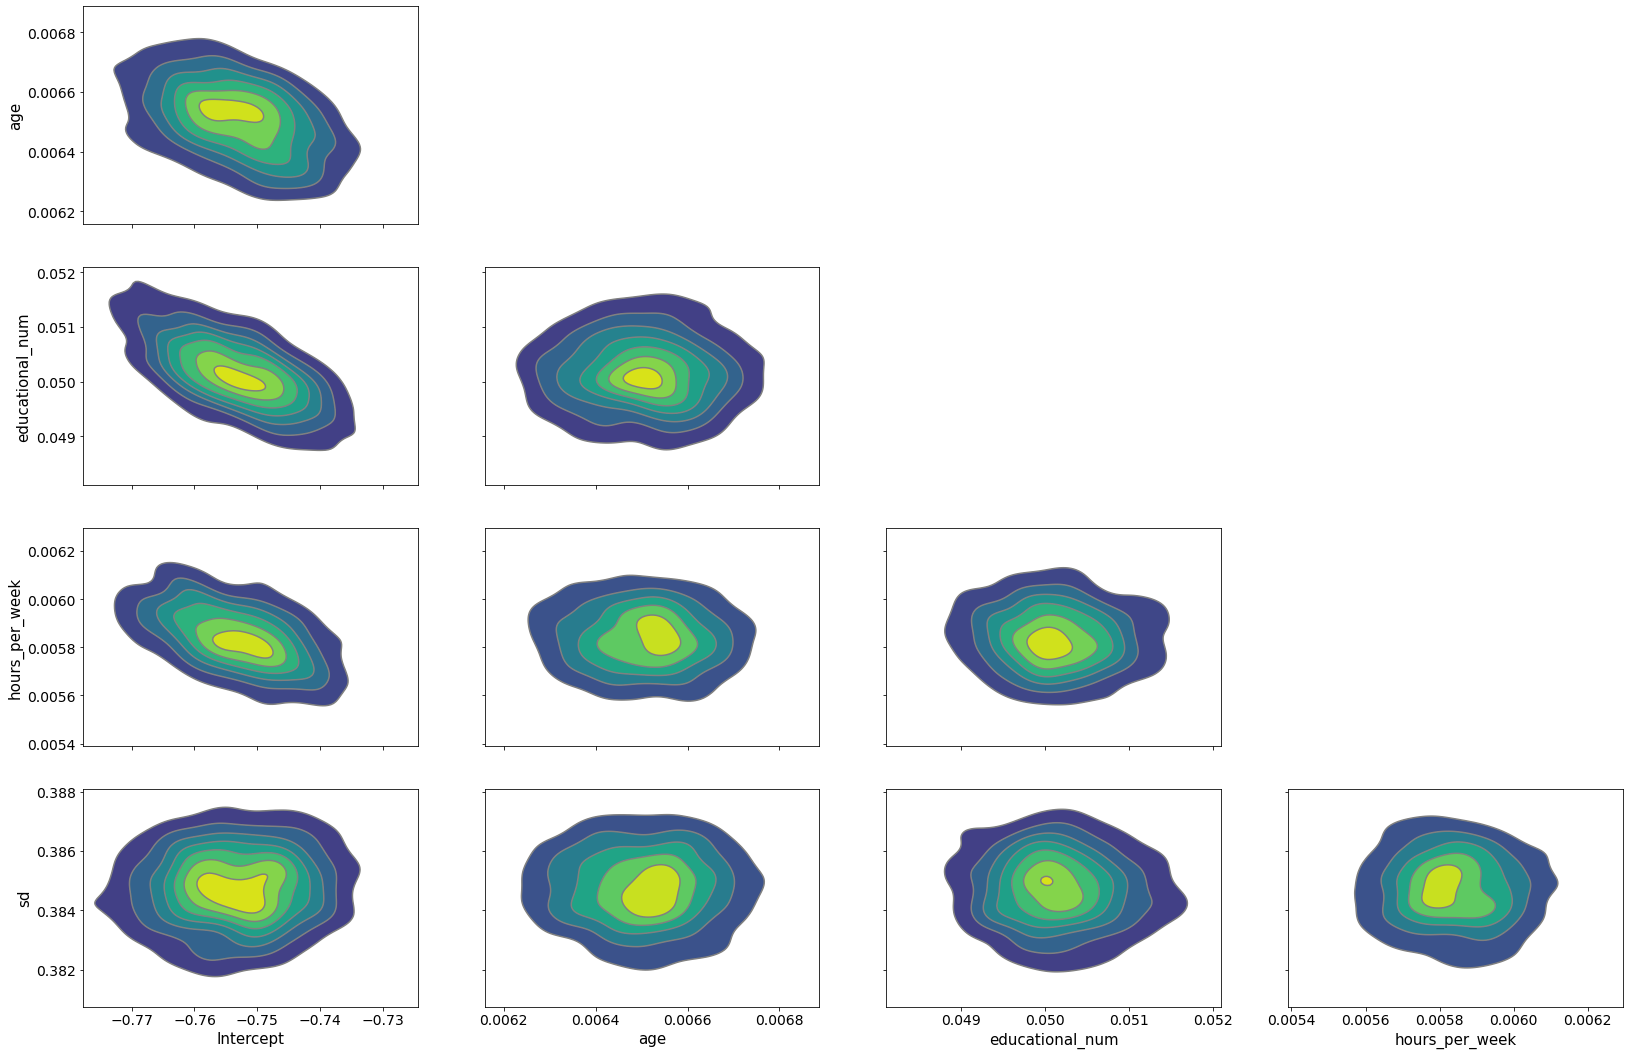

In [25]:
az.plot_pair(trace, kind='kde', fill_last=False);

In [26]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.753,0.009,-0.771,-0.737,0.0,0.0,352.0,499.0,1.01
age,0.007,0.000,0.006,0.007,0.0,0.0,912.0,776.0,1.00
educational_num,0.050,0.001,0.049,0.051,0.0,0.0,442.0,520.0,1.01
hours_per_week,0.006,0.000,0.006,0.006,0.0,0.0,634.0,613.0,1.01
sd,0.385,0.001,0.382,0.387,0.0,0.0,1125.0,785.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.


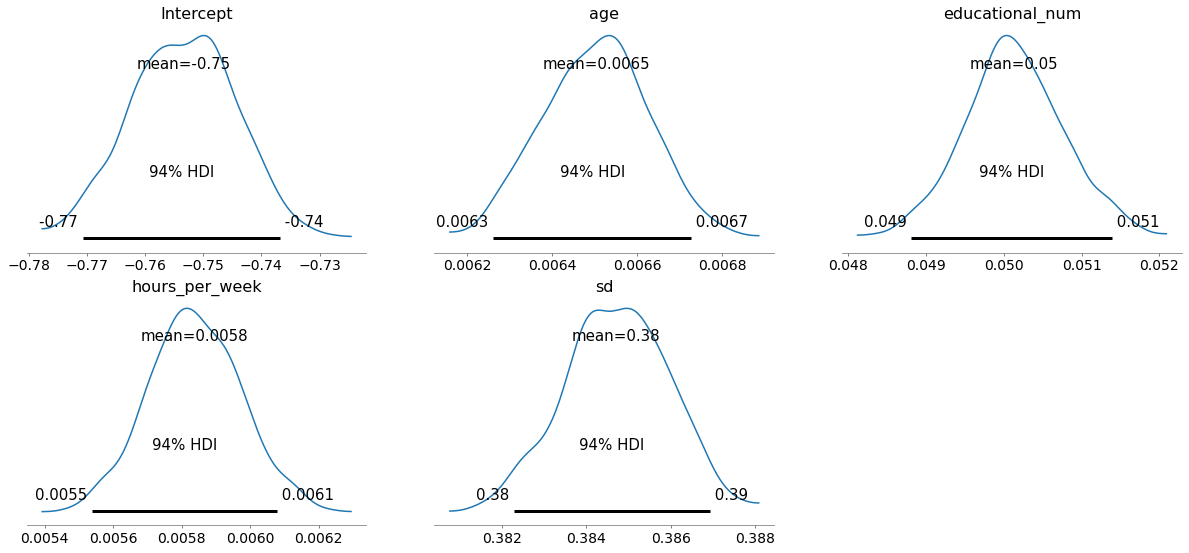

In [27]:
az.plot_posterior(trace);

Here we have try an other model

In [10]:
lower=-10**6
higher=10**6
with pm.Model() as s_model:
    #priors on parameters
    beta_0 =pm.Uniform('beta_0', lower=lower, upper= higher)
    #beta_income=pm.Uniform('beta_income', lower, higher)
    beta_age=pm.Uniform('beta_age', lower, higher)
    #beta_age2=pm.Uniform('beta_age2', lower, higher)
    beta_educational_num=pm.Uniform('beta_educational_num', lower, higher)
    beta_hours_per_week=pm.Uniform('beta_hours_per_week', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+    #beta_temp*df['income']-
                               beta_age*data['age']+
                               #beta_age2*df['age2']+
                               beta_educational_num*data['educational_num']+
                               beta_hours_per_week*data['hours_per_week']))
with s_model:
    #fit the data 
    observed=pm.Bernoulli("income", p, observed=data['income'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace_1=pm.sample(1000, step=step, start=start)
    burned_trace_1=trace_1[500:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_hours_per_week]
>Metropolis: [beta_educational_num]
>Metropolis: [beta_age]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 178 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
coeffs=['beta_0', 'beta_age', 'beta_educational_num', 'beta_hours_per_week']
d=dict()
for item in coeffs:
    d[item]=[burned_trace_1[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_age,beta_educational_num,beta_hours_per_week
0,-8.460701,0.045745,0.344696,0.042419


In [19]:
coeffs=['beta_0', 'beta_age', 'beta_educational_num', 'beta_hours_per_week']
d=dict()
for item in coeffs:
    d[item]=[float(start[item])]
    
map_coeffs=pd.DataFrame.from_dict(d)    
map_coeffs

,beta_0,beta_age,beta_educational_num,beta_hours_per_week
0,-8.479103,0.046103,0.345162,0.042358


# Machine learning Algorithm

both bayesain and ML features seems to be slightly different here.

In [20]:
from sklearn.linear_model import LogisticRegression
X=data
y=data['income']
data = data.drop('income', axis=1)
logit=LogisticRegression()
logit_model=logit.fit(X,y)
pd.DataFrame(logit_model.coef_, columns=X.columns)

,age,educational_num,hours_per_week,income
0,0.025723,0.169693,0.022289,14.234699
